In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np

In [4]:
# Load the dataset
df = pd.read_csv('unique_order_count.csv')
df['Year Month'] = pd.to_datetime(df['Year Month'])
df.set_index('Year Month', inplace=True)

# Sort the DataFrame by the 'Year Month' index
df.sort_index(inplace=True)
df

,Unique Order Count,Year,Month Number
Year Month,,,
2013-01-01,1674,2013,1
2013-02-01,1139,2013,2
2013-03-01,1683,2013,3
2013-04-01,1696,2013,4
2013-05-01,1808,2013,5
2013-06-01,1675,2013,6
2013-07-01,1886,2013,7
2013-08-01,1537,2013,8
2013-09-01,1617,2013,9


In [5]:
# Feature engineering - Transform the Date column
df['MonthsSinceStart'] = (df.index - df.index.min()).days // 30  # Assuming 30 days per month

In [9]:
# Define cutoff date for splitting
cutoff_date = df.index.max() - pd.DateOffset(months=3)

# Split data into training and testing sets
train_df = df[df.index < cutoff_date]
test_df = df[df.index >= cutoff_date]

# Prepare data for training
X_train, y_train = train_df[['MonthsSinceStart']], train_df['Unique Order Count']
X_test, y_test = test_df[['MonthsSinceStart']], test_df['Unique Order Count']

test_df

,Unique Order Count,Year,Month Number,MonthsSinceStart
Year Month,,,,
2015-11-01,1834,2015,11,34
2015-12-01,1951,2015,12,35
2016-01-01,1944,2016,1,36
2016-02-01,1706,2016,2,37


In [10]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Train the model
model = SVR(kernel='rbf')
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

In [12]:
# Calculate errors
errors_df = test_df[['Unique Order Count']].copy()
errors_df['pred_sales'] = predictions
errors_df['errors'] = predictions - y_test
errors_df.insert(0, 'model', 'SVR')

errors_df

,model,Unique Order Count,pred_sales,errors
Year Month,,,,
2015-11-01,SVR,1834,1737.708408,-96.291592
2015-12-01,SVR,1951,1737.252413,-213.747587
2016-01-01,SVR,1944,1736.779965,-207.220035
2016-02-01,SVR,1706,1736.307622,30.307622


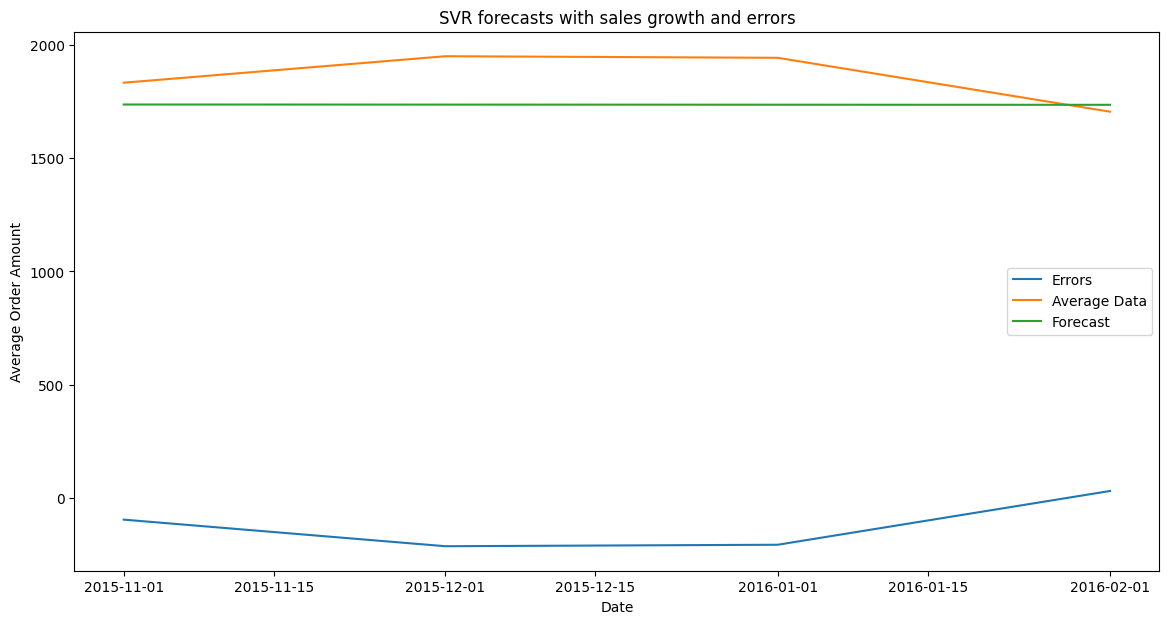

In [13]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(errors_df.index, errors_df['errors'], label='Errors')
ax.plot(errors_df.index, errors_df['Unique Order Count'], label='Average Data')
ax.plot(errors_df.index, errors_df['pred_sales'], label='Forecast')
ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('Average Order Amount')
ax.set_title('SVR forecasts with sales growth and errors')
plt.show()

In [14]:
# Calculate MAE, RMSE, and MAPE
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# Print the result metrics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Error (MAE): 136.89170925614025
Root Mean Squared Error (RMSE): 157.17728587965874
Mean Absolute Percentage Error (MAPE): 7.16053846351687


In [15]:
# Generate a forecast for the next 3 months
last_date = df.index.max()
last_day_of_last_month = pd.Timestamp(last_date.year, last_date.month, 1) + pd.offsets.MonthEnd(1)
first_day_of_next_month = last_day_of_last_month + pd.Timedelta(days=1)
forecast_dates = pd.date_range(start=first_day_of_next_month, periods=3, freq='MS')
months_since_start_forecast = (forecast_dates - df.index.min()).days // 30  # Assuming 30 days per month
X_forecast_scaled = scaler.transform(months_since_start_forecast.values.reshape(-1, 1))
forecast_predictions = model.predict(X_forecast_scaled)

C:\Users\geri0\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [17]:
# Print the forecast values
forecast_df = pd.DataFrame({'MonthsSinceStart': forecast_dates, 'Forecasted_Order_Count': forecast_predictions})
print(forecast_df)

  MonthsSinceStart  Forecasted_Order_Count
0       2016-03-01             1735.850069
1       2016-04-01             1735.419414
2       2016-05-01             1735.024783


In [18]:
# Reset the index of the original DataFrame
df.reset_index(inplace=True)

# Create a new DataFrame
new_df = df.copy()

# Drop unnecessary columns
new_df.drop(columns=['Month Number', 'Year', 'MonthsSinceStart'], inplace=True)

# Add a new column "Type" and populate it with "Historical Data"
new_df['Type'] = 'Historical Data'

# Append forecasted data
forecast_df = pd.DataFrame({'Year Month': forecast_dates, 'Unique Order Count': forecast_predictions})
forecast_df['Type'] = 'Predicted Data'

# Reset index of forecast_df
forecast_df.reset_index(drop=True, inplace=True)

# Concatenate historical and forecasted data
combined_df = pd.concat([new_df, forecast_df])

# Convert 'Year Month' to datetime type
combined_df['Year Month'] = pd.to_datetime(combined_df['Year Month'])

# Drop the existing index column
combined_df.reset_index(drop=True, inplace=True)

# Export the new data to a CSV file
combined_df.to_csv('unique_order_count_forecast.csv', index=False)